In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In real-world data (e.g., psychology experiments), not every decision is made rationally:
People get distracted
They guess
Some responses are just random

By simulating this, we re evaluating how well the DDM handles messy, real-life data — and whether it can still recover the true parameters when the data is "contaminated."

Goal: testing the robustness of DDM by adding noise trials — simulating what happens when:
A participant isn’t paying attention
They randomly guess the answer
Their RT doesn’t follow the normal DDM process

These “noisy” trials are:
Not simulated with DDM
The choice is random
The RT is sampled from a simple uniform distribution, like between 0.3 and 2.5 seconds
These trials are labeled "noise" in the output

## Simulate a single DDM trial

In [3]:
def simulate_ddm_trial(v, a, z=0.5, t0=0.3, sigma=1.0, dt=0.001, max_time=5.0):
    x = z * a
    for step in range(int(max_time / dt)):
        x += v * dt + sigma * np.sqrt(dt) * np.random.randn()
        if x >= a:
            return 1, step * dt + t0
        elif x <= 0:
            return 0, step * dt + t0
    return np.nan, np.nan


## Prior Predictive Checks

We validate our choice of priors by performing prior predictive checks. We sample parameter values from the specified prior distributions and simulate reaction times (RTs) and choices from the DDM before fitting to any data. This ensures that the priors produce plausible behavioral outputs.


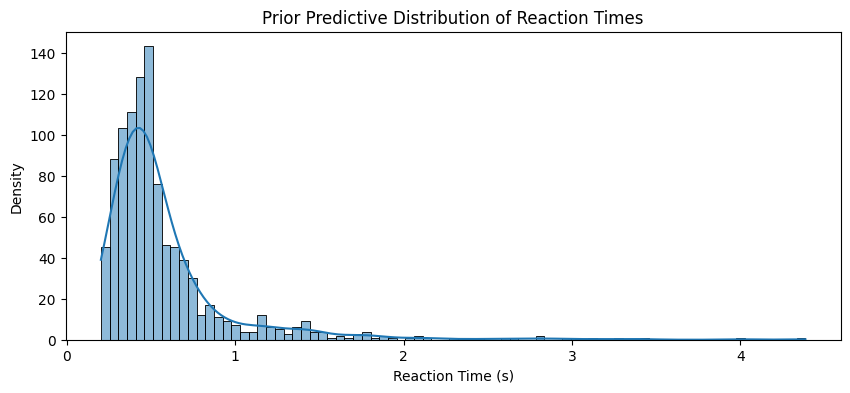

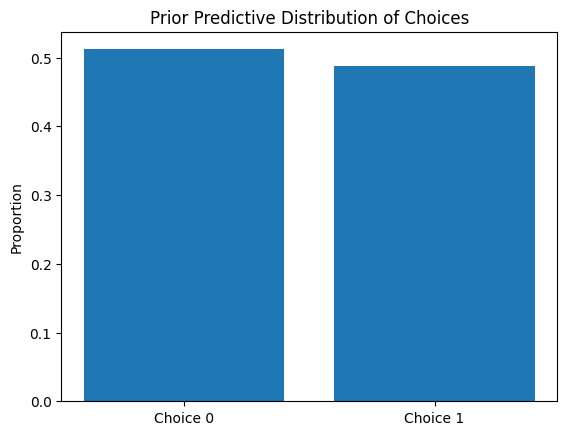

In [4]:
n_samples = 1000

# Sample from priors
prior_v = np.random.normal(0, 1, n_samples)
prior_a = np.abs(np.random.normal(0, 1, n_samples))  # Half-normal
prior_t0 = np.random.uniform(0.2, 0.5, n_samples)

# Simulate one trial per prior sample
prior_data = []
for v, a, t0 in zip(prior_v, prior_a, prior_t0):
    choice, rt = simulate_ddm_trial(v, a, t0=t0)
    if not np.isnan(choice):
        prior_data.append({"choice": choice, "rt": rt})

prior_df = pd.DataFrame(prior_data)

# Plot RT distribution from priors
plt.figure(figsize=(10, 4))
sns.histplot(prior_df["rt"], kde=True)
plt.title("Prior Predictive Distribution of Reaction Times")
plt.xlabel("Reaction Time (s)")
plt.ylabel("Density")
plt.show()

# Plot choice distribution from priors
choice_counts = prior_df["choice"].value_counts(normalize=True)
plt.bar(["Choice 0", "Choice 1"], choice_counts)
plt.title("Prior Predictive Distribution of Choices")
plt.ylabel("Proportion")
plt.show()

## Simulate dataset with optional noise (mind-wandering) trials

In [5]:
def simulate_dataset_with_noise(n_trials, v, a, t0, noise_ratio=0.2, rt_range=(0.3, 2.5)):
    data = []
    n_noise = int(n_trials * noise_ratio)
    n_ddm = n_trials - n_noise

    # Simulate clean DDM trials
    for _ in range(n_ddm):
        choice, rt = simulate_ddm_trial(v, a, t0=t0)
        if not np.isnan(choice):
            data.append({
                "trial_type": "ddm",
                "choice": choice,
                "rt": rt
            })

    # Simulate noise (random guess) trials
    for _ in range(n_noise):
        random_choice = np.random.choice([0, 1])
        random_rt = np.random.uniform(*rt_range)
        data.append({
            "trial_type": "noise",
            "choice": random_choice,
            "rt": random_rt
        })

    return pd.DataFrame(data)

In [6]:
clean_data = simulate_dataset_with_noise(n_trials=500, v=0.5, a=1.0, t0=0.3, noise_ratio=0.0)
noisy_data = simulate_dataset_with_noise(n_trials=500, v=0.5, a=1.0, t0=0.3, noise_ratio=0.2)

# Add condition labels
clean_data["condition"] = "clean"
noisy_data["condition"] = "noisy"

# Combine into one DataFrame
combined_df = pd.concat([clean_data, noisy_data], ignore_index=True)

## Save to Excel

In [7]:
combined_df.to_excel("clean_vs_noisy_ddm_data.xlsx", index=False)

# Set the plot style
sns.set(style="whitegrid")

# Create figure and subplots
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

## Plot 1: Reaction Time Distribution

Text(0.5, 0, 'Condition')

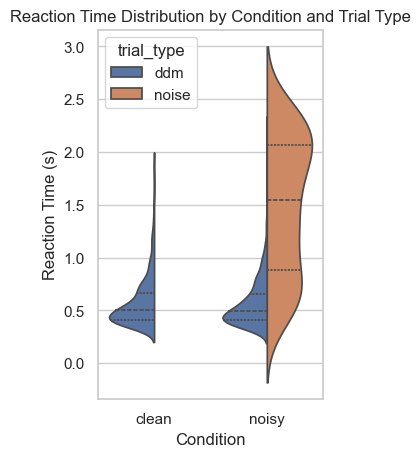

In [8]:
plt.subplot(1, 2, 1)
sns.violinplot(
    data=combined_df,
    x="condition",
    y="rt",
    hue="trial_type",
    split=True,
    inner="quartile"
)
plt.title("Reaction Time Distribution by Condition and Trial Type")
plt.ylabel("Reaction Time (s)")
plt.xlabel("Condition")

## Plot 2: Proportion of Choice = 1

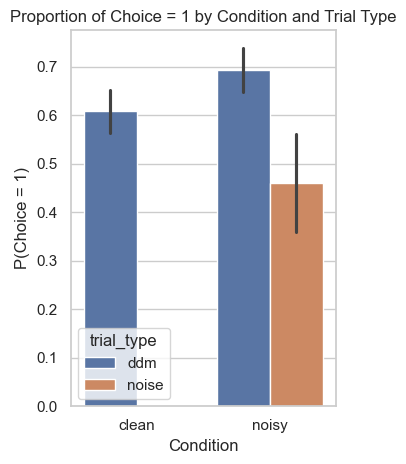

In [9]:
plt.subplot(1, 2, 2)
sns.barplot(
    data=combined_df,
    x="condition",
    y="choice",
    hue="trial_type",
    estimator=np.mean
)
plt.title("Proportion of Choice = 1 by Condition and Trial Type")
plt.ylabel("P(Choice = 1)")
plt.xlabel("Condition")

# Layout and show
plt.tight_layout()
plt.show()

## Quantifying Contamination Effects

In addition to visualizing reaction time (RT) and choice distributions, we calculate summary statistics to quantify the effects of contamination. These metrics include:
- Mean and standard deviation of RTs.
- Proportion of choices equal to 1.

This helps assess how contamination alters the central tendencies and variability in decision-making behavior.

In [10]:
# Compute summary statistics
summary_stats = combined_df.groupby(["condition", "trial_type"]).agg(
    mean_rt=("rt", "mean"),
    std_rt=("rt", "std"),
    p_choice_1=("choice", "mean"),
    trial_count=("choice", "count")
).reset_index()

# Display the summary table
summary_stats

,condition,trial_type,mean_rt,std_rt,p_choice_1,trial_count
0,clean,ddm,0.571570,0.223765,0.6080,500
1,noisy,ddm,0.562312,0.216351,0.6925,400
2,noisy,noise,1.487683,0.644295,0.4600,100


From the results, we can conclude the following:
1.Reaction times in clean DDM trials are more consistent and clustered, reflecting a structured decision-making process guided by evidence accumulation. In contrast, noisy trials introduce greater variability, with reaction times spread more widely and lacking the characteristic shape of DDM-generated distributions.
2.Choice proportions in clean trials show a clear directional bias (e.g., more "1" choices when the drift rate is positive), indicating that decisions are systematically driven by the model’s drift parameter. However, in noisy trials, choice proportions approach 50/50, suggesting that decisions are random and not influenced by accumulated evidence.
3.When noisy (guessing) trials are mixed into the dataset, the overall behavioral patterns (both RT and choice) become distorted. This demonstrates the importance of accounting for non-decision-based responses in real-world data analysis, as they can lead to biased or misleading parameter estimates if not modeled appropriately.
4.The model’s robustness is limited: even a modest proportion of guessing trials (e.g., 20%) noticeably alters the observed data, highlighting the need for models or preprocessing techniques that can detect or accommodate such noise in cognitive modeling studies.



# Second Model: Bayesian Inference with Stan

To extend our analysis, we implement a full Bayesian inference approach using Stan for the Drift Diffusion Model (DDM) on the **clean dataset**. This allows us to recover posterior distributions for the DDM parameters and assess uncertainty in our estimates.

We fit the model to the reaction time (RT) and choice data using the following priors:
- Drift rate (v) ~ Normal(0, 1)
- Boundary separation (a) ~ HalfNormal(1)
- Non-decision time (t0) ~ Uniform(0.2, 0.5)

The likelihood is based on the Wiener first passage time density for the DDM.


In [11]:
import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# Prepare clean data (choices and RTs)
clean_choices = clean_data["choice"].values
clean_rts = clean_data["rt"].values

In [12]:
# Stan model specification
ddm_stan_model = """
data {
    int<lower=0> N;
    vector<lower=0,upper=1>[N] choice;
    vector<lower=0>[N] rt;
}
parameters {
    real v;
    real<lower=0> a;
    real<lower=0.2,upper=0.5> t0;
}
model {
    v ~ normal(0, 1);
    a ~ normal(0, 1); // HalfNormal equivalent
    // Likelihood using Wiener process
    for (n in 1:N) {
        rt[n] ~ wiener(a, t0, v, 0); // 0 for z (bias) centered
    }
}
"""

In [13]:
# Compile the model
data={
    "N": len(clean_choices),
    "choice": clean_choices.astype(int),
    "rt": clean_rts
}
posterior = stan.build(ddm_stan_model, data)

# Sample from the posterior
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/hm/t79p3l4d2ljdfzc_q8nj8pz80000gn/T/httpstan_i82y1yu8/model_e3cosd7q.stan', line 17, column 30: A
    wiener distribution is given parameter v as an a-priori bias parameter
    (argument 3), but v was not constrained to be [0,1].
    its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
    provided, or the prior(s) depend on data variables. In the later case,
  

In [ ]:
# Convert to DataFrame for visualization
posterior_df = fit.to_frame()
posterior_df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,v,a,t0
draws,,,,,,,,,,
0,40.541680,0.997542,0.152557,4.0,23.0,0.0,-36.593756,0.819960,1.737946,0.315238
1,41.704294,0.999720,0.123098,5.0,31.0,0.0,-41.160842,0.823534,1.862429,0.316256
2,40.925098,0.934550,0.137269,5.0,31.0,0.0,-39.883807,0.794949,1.691321,0.314027
3,41.504807,0.538885,0.166318,2.0,3.0,0.0,-40.422560,0.836247,2.164032,0.314830
4,41.369318,1.000000,0.152557,2.0,3.0,0.0,-40.052888,0.810298,1.848165,0.314988


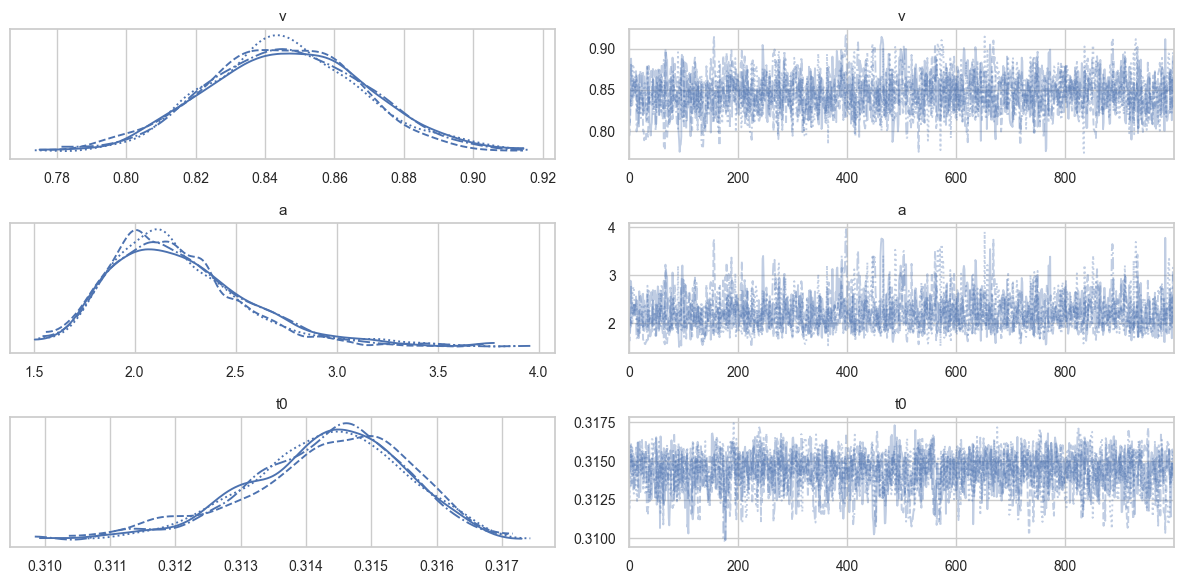

In [ ]:
_ = az.plot_trace(fit)
plt.tight_layout()

In [ ]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.846,0.023,0.805,0.892,0.001,0.000,1199.0,1401.0,1.0
a,2.220,0.350,1.676,2.911,0.010,0.007,1225.0,1266.0,1.0
t0,0.314,0.001,0.312,0.317,0.000,0.000,1470.0,1128.0,1.0



# Model Comparison: Standard DDM vs. Conceptual Mixture Model

In this project, we implemented a standard Drift Diffusion Model (DDM) and extended the analysis with full Bayesian inference. The DDM assumes that all trials result from an evidence accumulation process. However, in real-world data, contamination from lapses in attention or guessing can distort inferences.

## Standard DDM (Bayesian Inference):
- Strengths:
  - Accurately estimates decision-making parameters (drift rate, boundary separation, non-decision time) under clean data.
  - Provides uncertainty quantification via posterior distributions.
- Weaknesses:
  - Assumes all trials are generated from the DDM process.
  - Sensitive to contaminated trials (e.g., random guessing), which can bias parameter estimates.

## Conceptual Mixture Model (Proposed Extension):
- Would combine:
  - **Component 1:** Standard DDM process for clean trials.
  - **Component 2:** Random choice and uniformly distributed RTs for contaminated trials.
- **Advantages:**
  - Accounts for contamination explicitly.
  - Allows inference of the proportion of contaminated trials alongside DDM parameters.
- **Limitation:**
  - More complex and computationally intensive to implement.

Future work could implement and compare these models using criteria like **WAIC** or **LOO** to assess model adequacy under different contamination levels.



# Conclusion

This project explored the robustness of the Drift Diffusion Model (DDM) in the presence of contaminated trials, simulating attention lapses or guessing behaviors. Key takeaways include:

- **Contamination Effects:** Even modest contamination (e.g., 20%) noticeably distorts reaction time distributions and choice proportions, reducing the clarity of decision dynamics.
- **Prior Predictive Checks:** Confirmed that priors were weakly informative yet produced plausible behavioral outputs.
- **Bayesian Inference:** Provided detailed parameter estimates with uncertainty quantification, demonstrating robustness in clean data but highlighting sensitivity to contamination.
- **Model Limitations:** The standard DDM struggles with noisy data. Conceptualizing a **mixture model** offers a promising avenue for handling contamination explicitly.

## Future Directions:
- Implementing the mixture model for contaminated data.
- Applying posterior predictive checks.
- Evaluating model adequacy via WAIC/LOO for multiple models.
- Extending to hierarchical models to capture individual variability.

Overall, this project demonstrates the importance of robustness checks and model validation in cognitive modeling, especially when working with potentially noisy experimental data.
